# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Module importations</strong></span>

In [1]:
import scipy.io
import os
import h5py
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# from scipy.stats import sem
from scipy.stats import wilcoxon
import pandas as pd

C:\Users\gbouvier\AppData\Local\Temp\ipykernel_20856\846297231.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
%matplotlib widget 
plt.ioff()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>FUNCTIONS</strong></span>

## filepath(path, file)

In [3]:
def filepath(path, file):
    return os.path.join(path, file) 

## plots(row_number, col_number, width, height, *args, suptitle=None,**kwargs)

In [4]:
def plots(row_number, col_number, *args, suptitle=None, **kwargs):
    if len(args) != row_number * col_number:
        raise ValueError("Le nombre d'arguments fournis ne correspond pas au nombre de sous-graphiques attendus.")
    
    fig, axs = plt.subplots(row_number, col_number)#, figsize=(width, height))
    
    # Flatten axes if there's only one row or one column
    if row_number == 1 or col_number == 1:
        axs = axs.reshape(-1)
    
    for i, plot_call in enumerate(args):
        if row_number > 1 and col_number > 1:  # If there's more than one row and more than one column
            col = i // row_number
            row = i % row_number
            ax = axs[row, col]
        else:  # If there's only one row or one column
            ax = axs[i]
        plot_call(ax)

    for ax in axs.flat:
        ax.set(**kwargs)

    plt.suptitle(suptitle)

    # plt.tight_layout()
    # fig.set_tight_layout(True)

    plt.show()

## plotVelocity(velocity)

In [5]:
def plotVelocity(velocity, color='c', ax='', xlabel=True, ylabel=True):
    if ax:
        ax.plot(duration, velocity, color=color, linewidth='1')
        ax.set_ylim(-rotationSpeed, rotationSpeed)
        ax.set_xlim(-timeBef, timeAft)
        if ylabel:
            ax.set_ylabel(r'Mean Velocity $(^\circ/s)$')
        if xlabel:
            ax.set_xlabel(r'Time $(s)$')
        ax.set_yticks([-rotationSpeed, 0, rotationSpeed])
    else:
        plt.plot(duration, velocity, color=color, linewidth='1')
        plt.ylim(-rotationSpeed, rotationSpeed)
        plt.xlim(-timeBef, timeAft)
        if ylabel:
            plt.ylabel(r'Mean Velocity $(^\circ/s)$')
        if xlabel:
            plt.xlabel(r'Time $(s)$')
        plt.yticks([-rotationSpeed, 0, rotationSpeed])
        plt.show()

## plotRaster(spikeTimesObject)

In [6]:
def plotRaster(spikeTimesObject, color='black', ax='', xlabel=True, ylabel=True, extra=None, title=''):

    linelengths = 1

    if ax:
        # for trial_id, spike_times in enumerate(spikeTimesObject):
        #     ax.eventplot(spike_times, lineoffsets=trial_id+1, linelengths=linelengths, color=color)

        ax.eventplot(spikeTimesObject, linelengths=linelengths, colors=color)

        if ylabel:
            ax.set_ylabel('# Trial')
        if xlabel:
            ax.set_xlabel('Time (s)')
            
        ax.set_title('')
        ax.set_xlim(-timeBef,timeAft)
        
        ### annulate the offset due to python indexation
        def custom_formatter(x, pos):
            return f"{int(x) + 1}"
        ax.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

        ax.set_ylim(0-linelengths/2,len(spikeTimesObject)-1+linelengths/2)

        if extra is not None:
            extra()
        
        ax.set_title(title)
            
    else:
        # for trial_id, spike_times in enumerate(spikeTimesObject):
        #     plt.eventplot(spike_times, lineoffsets=trial_id+1, linelengths=linelengths, color=color)

        plt.eventplot(spikeTimesObject, linelengths=linelengths, colors=color)


        if extra is not None:
            extra()
        
        if ylabel:
            plt.ylabel('# Trial')
        if xlabel:
            plt.xlabel('Time (s)')
        
        plt.title('')
        plt.xlim(-timeBef,timeAft)

        ### annulate the offset due to python indexation
        def custom_formatter(x, pos):
            return f"{int(x) + 1}"
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

        plt.ylim(0-linelengths/2,len(spikeTimesObject)-1+linelengths/2)

        plt.title(title)

        plt.show()

## plotPSTH(StudiedSpikeTimes)

In [81]:
def plotPSTH(StudiedSpikeTimes,color='k',shadedcolor='c',binResolution = 0.03,ax='',xlabel=True,ylabel=True):
    if ax:
        local_trial_number = len(StudiedSpikeTimes)

        spike_number_per_trial = [[] for _ in range(local_trial_number)]
        edges = []
        unitary_firing_rate = [[] for _ in range(local_trial_number)]

        for trial in range(local_trial_number):
            spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

        frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
        mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

        Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
        Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
        SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))


        # plt.figure(figsize=(15,6))
        ax.plot(edges[:-1], Zscore, color=color)
        ax.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        ax.set_xlim(-timeBef,timeAft)
        if ylabel:
            ax.set_ylabel('PSTH')
        if xlabel:
            ax.set_xlabel('Time (s)')
    else:
        local_trial_number = len(StudiedSpikeTimes)

        spike_number_per_trial = [[] for _ in range(local_trial_number)]
        edges = []
        unitary_firing_rate = [[] for _ in range(local_trial_number)]

        for trial in range(local_trial_number):
            spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

        frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
        mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

        Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
        Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
        SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))


        # plt.figure(figsize=(15,6))
        plt.plot(edges[:-1], Zscore, color=color)
        plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        plt.xlim(-timeBef,timeAft)
        if ylabel:
            plt.ylabel('PSTH')
        if xlabel:
            plt.xlabel('Time (s)')
        plt.show()

## figure1(unit)

In [8]:
def figure1(unit,firstcolor='c',secondcolor='k',binResolution=0.03,suptitle='Figure 1 unit'):
      plots(3, 2,
            lambda ax: plotVelocity(MeanRotation['first']['CW'],color=firstcolor, ax=ax, xlabel=False),
            lambda ax: plotRaster(SpikeTimes['first']['CW'][unit], color=firstcolor, ax=ax, xlabel=False),
            lambda ax: plotPSTH(SpikeTimes['first']['CW'][unit],color=firstcolor, shadedcolor=firstcolor, ax=ax),
            lambda ax: plotVelocity(MeanRotation['second']['CCW'],color=secondcolor,ax=ax,ylabel=False,xlabel=False),
            lambda ax: plotRaster(SpikeTimes['second']['CCW'][unit], color=secondcolor, ax=ax,xlabel=False,ylabel=False),
            lambda ax: plotPSTH(SpikeTimes['second']['CCW'][unit],color=secondcolor, shadedcolor=secondcolor, ax=ax,ylabel=False),
            suptitle=suptitle
      )

## seeModulation(condition, modulated)

In [9]:
def seeModulation(condition,modulated):
      position = np.where([(modulation[condition][neuron]['selectivity']==modulated.split()[0]) and (modulation[condition][neuron]['type']==modulated.split()[1]) for neuron in range(Nclust)])[0]
      print(f'The {modulated} modulated neurons are {position}')

      for unit in np.where([(modulation[condition][neuron]['selectivity']==modulated.split()[0]) and (modulation[condition][neuron]['type']==modulated.split()[1]) for neuron in range(Nclust)])[0]:
            plots(1,2,
                  lambda ax: plotRaster(SpikeTimes[condition]['CW'][unit], ax=ax),
                  lambda ax: plotRaster(SpikeTimes[condition]['CCW'][unit], ax=ax, ylabel=False)
                  )

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Created variables</strong></span>

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Paths</strong></span>

In [10]:
import tkinter as tk
from tkinter import filedialog

# Créer une fenêtre Tkinter
root = tk.Tk()
root.withdraw()  # Cacher la fenêtre principale

# Afficher la boîte de dialogue de sélection de dossier
selected_path = filedialog.askdirectory()

In [11]:
parent_folder = os.path.dirname(selected_path)
# saving_folder_path = os.path.join(selected_path, 'Abdussamed_analyze')

index_animal = selected_path.find('animal')
exp_id = selected_path[index_animal:]
exp_id = exp_id[:16]

saving_

cleaned_path = os.path.normpath(selected_path)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Determination of parameters</strong></span>

In [12]:
## Studied conditions
# studied_unit      = 1            # (false if all)
# studied_channel   = list(range(1, 36+1))
# WhichCondition    = ['First condition','Second condition']
# RotationDirection = ['CW','CCW']

## Parameters
timeBef           = 1                  # seconde, for trial sectionning
timeAft           = 5                  # seconde, for trial sectionning
# binResolution     = 0.01               # seconde, for PSTH
refValue          = 'din04'
chanSpace         = 20                 #um
rotationSpeed     = 80                 #deg/s
ProbeType         = '32_optoElectrode'

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Data importation</strong></span>

In [13]:
clusterParam = h5py.File(os.path.join(selected_path,'rez.mat'),'r')['rez']
infos = clusterParam['ops'] 
f = int(infos['fs'][0][0])

c_class = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['cluster_class']  # units and associated time spiking

temp_idx = c_class[:,0]    # units
# find the units and remove the MUA
units = temp_idx!=0
temp_clus = c_class[units,0]

Nclust = len(np.unique(temp_clus))


# if not studied_unit:
#     studied_unit = list(range(1,Nclust+1))


temp_time = c_class[units,1]/1000  # temps de spike en seconde

temp_time_clust = []
for unit in range(1, Nclust+1):
    temps_spikes_sec = [c[1] / 1000 for c in c_class if c[0] == unit]  # Extraction des temps de spikes en secondes par unité
    temp_time_clust.append(np.ravel(temps_spikes_sec))

table_velocity = np.ravel(h5py.File(os.path.join(parent_folder, exp_id + '_ADC00.mat'), 'r')['data'])

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>DIN importation & ref selection</strong></span>

In [14]:
os.chdir(parent_folder)

#Load all the digital Input on the workspace

#DIN01 => photodiiode 1 is trig CAM
#DIN02 => LED
#DIN03 => trig ttl frame camera
#DIN04 => photodiiode 2 is the VS and start turntable

din = {
    '01':[],
    '02':[],
    '03':[],
    '04':[]
}

for dinkey in din.keys():
    dinkey = str(dinkey)
    filename = exp_id + '_DIN'+ dinkey + '.mat'
    din[dinkey] = np.ravel(h5py.File(filename, 'r')['data'])

In [15]:
if refValue == 'din01':
    ref = din['01']
elif refValue == 'din02':
    ref = din['02']
elif refValue == 'din03':
    ref = din['03']
elif refValue == 'din04':
    ref = din['04']
else:
    print('Take a look to the indicated ref din')

In [16]:
time = np.arange(len(din['01'])) / f

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Trials beginning</strong></span>

In [17]:
dref = np.diff(ref)
dref = np.insert(dref, 0, 0)

position_max = np.where(ref == 1)[0]

peaks = np.where(dref == 1)[0]
pic_position = np.array([peaks[0]])

thresholdTime = np.where(dref == -1)[0][0] - np.where(dref == 1)[0][0] + 1 * f

for i in range(len(peaks) - 1, 0, -1):
    if peaks[i] - peaks[i - 1] > thresholdTime:
        pic_position = np.append(pic_position, peaks[i])

pic_position = np.sort(pic_position)

Ntrial = len(pic_position)

print("Number of trials :", Ntrial)
print(pic_position[0:100])

Number of trials : 173
[ 1013677  1257883  1502090  1746296  1990002  2234709  2478915  2723622
  2967829  3211535  3455241  3699947  3944654  4188861  4433067  4676773
  4920979  5165686  5409893  5653598  5897304  6141511  6385217  6629423
  6873129  7116836  7360542  7604748  7848954  8093661  8338368  8582575
  8827281  9071488  9316194  9560401  9805108 10049314 10293020 10537226
 10781432 11025139 11268845 11513051 11756757 12000963 12245170 12490377
 12734584 12978790 13222495 13466702 13710908 13954615 14198821 14338450
 14459552 20409069 20715828 21019085 21325844 21632103 21935859 22242118
 22548377 22852134 23158392 23465151 23771411 24074665 24381426 24688186
 24994444 25301203 25604459 25907716 26213975 26520734 26823990 27127247
 27434506 27737762 28044521 28350780 28654037 28957293 29263552 29570311
 29873567 30176823 30483083 30789842 31093098 31395854 31699110 32001866
 32305122 32611882 32732079 32918641]


# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Protocol separation</strong></span>

In [18]:
# Find protocol separation index
mediane_NindexBetweenTrials = np.median(np.diff(pic_position))  # en # indices
thresholdProtocol = 5 * mediane_NindexBetweenTrials  # seuil en indice
thresholdIndex = pic_position[np.ravel(np.where(np.diff(pic_position) > thresholdProtocol))[0]]  # indice d'exclusion
thresholdTrial = np.where(pic_position > thresholdIndex)[0][0]  # trial d'exclusion

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Rotation objects</strong></span>

In [19]:
RotationWise = {
    'first': [],
    'second': []
}

Rotation = {
    'first': {
        'CW' : [],
        'CCW': [],
        'NotResponding': []
    },
    'second': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    }
}


comparateur = np.mean(table_velocity[:10*f])
coefficient = 0.5

for trial in range(Ntrial):
    lowerIdx = pic_position[trial] - timeBef*f
    upperIdx = pic_position[trial] + timeAft*f
    velocityBetween = table_velocity[lowerIdx:upperIdx]
    seuilCW = velocityBetween > comparateur*(1+coefficient)
    seuilCCW = velocityBetween < comparateur*(1-coefficient)

    if np.sum(seuilCW) != 0:
        if trial < thresholdTrial:
            RotationWise['first'].append('CW')
            Rotation['first']['CW'].append(velocityBetween)
        else:
            RotationWise['second'].append('CW')
            Rotation['second']['CW'].append(velocityBetween)
    elif np.sum(seuilCCW) != 0:
        if trial < thresholdTrial:
            RotationWise['first'].append('CCW')
            Rotation['first']['CCW'].append(velocityBetween)
        else:
            RotationWise['second'].append('CCW')
            Rotation['second']['CCW'].append(velocityBetween)
    else:
        if trial < thresholdTrial:
            RotationWise['first'].append('NotResponding')
            Rotation['first']['NotResponding'].append(velocityBetween)
        else:
            RotationWise['second'].append('NotResponding')
            Rotation['second']['NotResponding'].append(velocityBetween)

# Convertir les listes en tableaux NumPy
RotationWise['first'] = np.array(RotationWise['first'])
RotationWise['second'] = np.array(RotationWise['second'])

for direction in ['CW', 'CCW', 'NotResponding']:
    Rotation['first'][direction] = np.array(Rotation['first'][direction])
    Rotation['second'][direction] = np.array(Rotation['second'][direction])

duration = np.arange(-timeBef, timeAft, 1/f)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Determination of depths</strong></span>

BEGINNING OF WORK

In [20]:
m_class = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['mua_class']
muaWf = scipy.io.loadmat(os.path.join(selected_path,'times_polytrodeAll.mat'))['clusWFmua']

# find the all the units (unsorted good and mua)
temp_clus_mua = m_class[:,0] # these are the indice of the cluster for each index
# get the number of units
clustWho_mua = np.unique(temp_clus_mua)
Nclust_mua = len(clustWho_mua)
ind_mua = temp_clus_mua

temp_time_mua = m_class[:,1]/1000 # these are the indice of the cluster for each index
time_cluster_mua = temp_time_mua


# find the peak wf to find the depth
szm = muaWf.shape
# DEPTH of the unit
# Get the mua activity that is in index 0 of the clusWF

allBasem = np.zeros((szm[1],szm[2]))
PkDepthUnit = np.zeros((szm[0], 1))
minMatrixm = np.zeros((szm[0], 1))

for spm in range(szm[0]):
    baselinem = np.mean(muaWf[spm][0:5],axis=0)-500 # offset -500 for potential positive baseline
    for bm in range(szm[2]):
        allBasem[:,bm] = baselinem[bm]*np.ones((szm[1]))

    spikeWavm = muaWf[spm,:,:]-500
    # subtract the baseline
    wfm = spikeWavm - allBasem
    # get the min 
    minMatrixm[spm] = np.min(wfm)


    argMm = np.where(wfm==minMatrixm[spm])
    # get the depth of the unit
    uout = np.unique(argMm[1])
    argMm = []
    argMm = uout[0]
    PkDepthUnit[spm] = (argMm+1)*chanSpace # +1 because of Python indexation

In [66]:
x = 0

mapp = np.squeeze(infos['chanMap'])
Ntet = 16 if len(mapp)==32 else print('WEIRD NUMBER OF TETRODES')

ArgallLayers = {i: [] for i in range(Ntet)}

factorTet = chanSpace * len(mapp)/Ntet

for lay in range(Ntet):
    # H5 electrode
    if np.sum(mapp[0:4]==[33, 38, 44, 40])==4:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    else:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+chanSpace*len(mapp)/Ntet) & (PkDepthUnit > x))[0]
    x += factorTet

In [67]:
m_class_tet = np.zeros((len(m_class),2))

m_class_tet[:,1] = m_class[:,1]

for tet in ArgallLayers:
    for unit in ArgallLayers[tet]:
        pos = np.where(m_class[:,0]-1 == unit)[0]
        m_class_tet[pos,0] = tet

In [68]:
AllSpikeTimesMUA = np.empty((Ntet,Ntrial),dtype=object)


for tet in range(Ntet):
    spikingTimeTet = m_class_tet[np.where(m_class_tet[:,0] == tet)[0],1]/1000

    for trial in range(Ntrial):
        upperTime = pic_position[trial]/f + timeAft
        lowerTime = pic_position[trial]/f - timeBef
        bornes = np.where((spikingTimeTet > lowerTime) & (spikingTimeTet < upperTime))[0]
        AllSpikeTimesMUA[tet][trial] = spikingTimeTet[bornes] - lowerTime - timeBef

In [69]:
SpikeTimesMUA = {
    'first': {
        'CW': [[] for _ in range(Ntet)],
        'CCW': [[] for _ in range(Ntet)],
        'NotResponding': [[] for _ in range(Ntet)]
    },
    'second': {
        'CW': [[] for _ in range(Ntet)],
        'CCW': [[] for _ in range(Ntet)],
        'NotResponding': [[] for _ in range(Ntet)]
    }
}


for tet in range(len(AllSpikeTimesMUA)):
    for trial in range(Ntrial):
        if trial < thresholdTrial:
            condition = 'first'
            trialIndex = trial
            if RotationWise[condition][trialIndex] == 'CW':
                direction = 'CW'
            elif RotationWise[condition][trialIndex] == 'CCW':
                direction = 'CCW'
            elif RotationWise[condition][trialIndex] == 'NotResponding':
                direction = 'NotResponding'
        else:
            condition = 'second'
            trialIndex = trial - thresholdTrial
            if RotationWise[condition][trialIndex] == 'CW':
                direction = 'CW'
            elif RotationWise[condition][trialIndex] == 'CCW':
                direction = 'CCW'
            elif RotationWise[condition][trialIndex] == 'NotResponding':
                direction = 'NotResponding'
        
        SpikeTimesMUA[condition][direction][tet].append([AllSpikeTimesMUA[tet][trial]])

# for condition in SpikeTimesMUA:
#     for direction in SpikeTimesMUA[condition]:
#             SpikeTimesMUA[condition][direction] = np.array(SpikeTimesMUA[condition][direction], dtype=object)
        
for condition in SpikeTimesMUA:
    for direction in SpikeTimesMUA[condition]:
        for tet in range(len(SpikeTimesMUA[condition][direction])):
            SpikeTimesMUA[condition][direction][tet] = np.array([SpikeTimesMUA[condition][direction][tet][trial][0] for trial in range(len(SpikeTimesMUA[condition][direction][tet]))], dtype=object)


In [ ]:
[plotRaster(SpikeTimesMUA['second']['CW'][tet]) for tet in range(Ntet)]

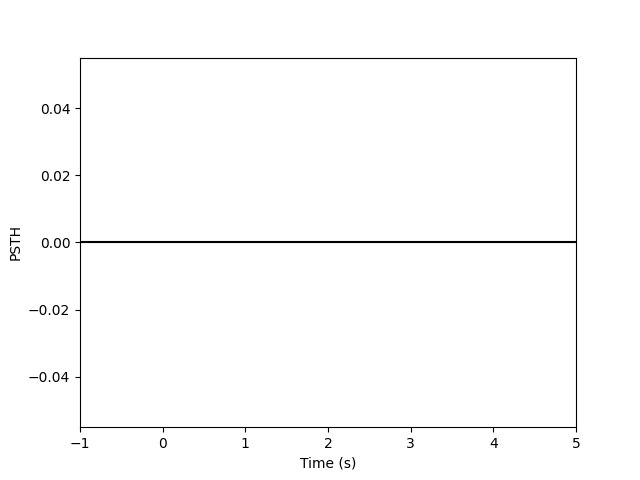

In [82]:
plotPSTH(SpikeTimesMUA['second']['CW'][1])

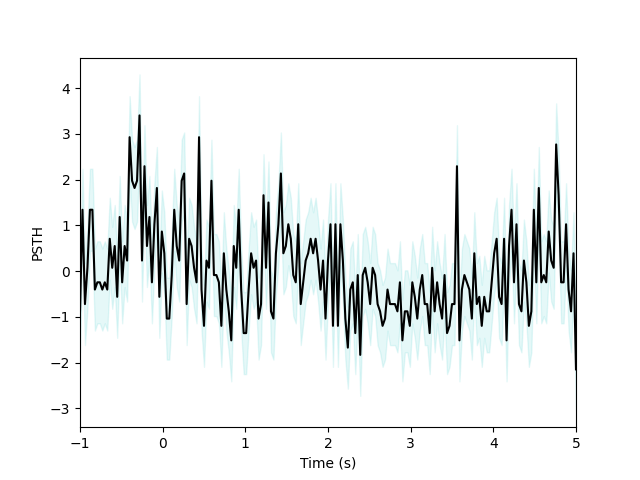

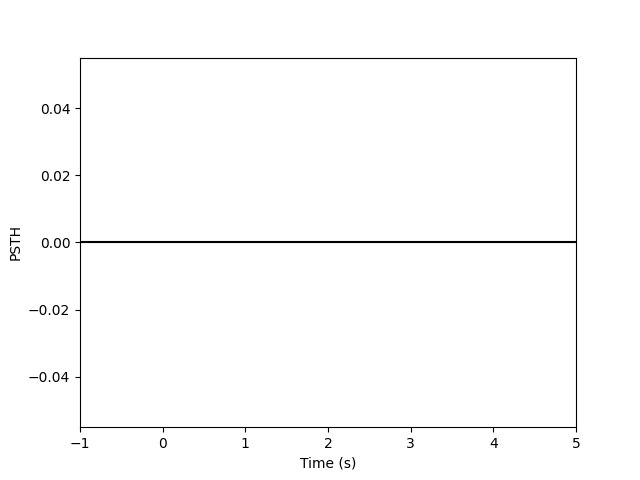

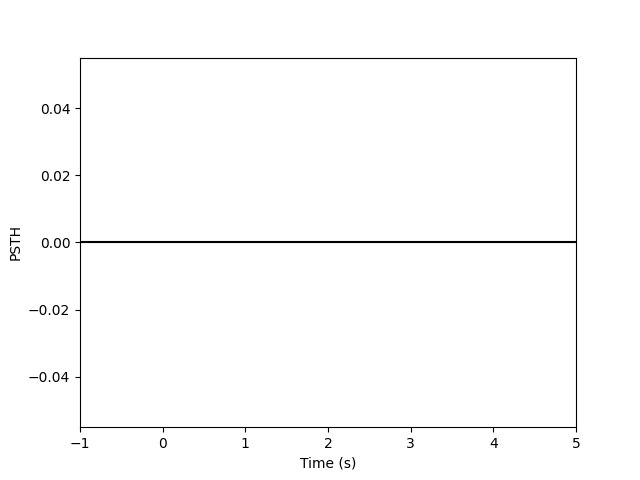

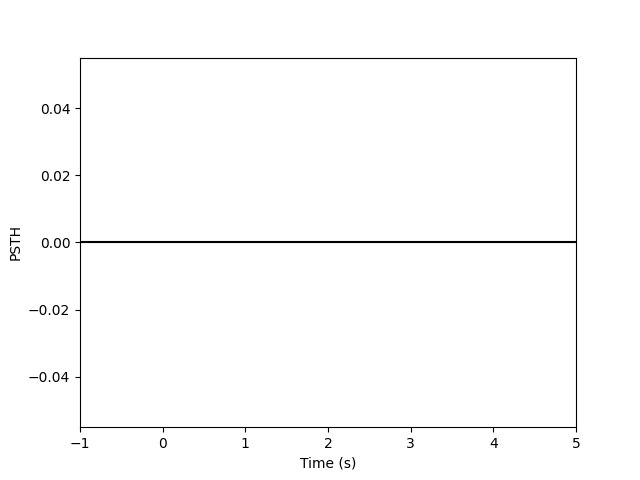

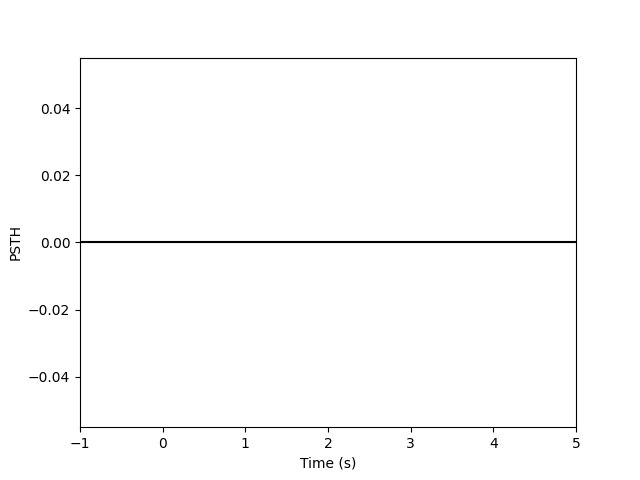

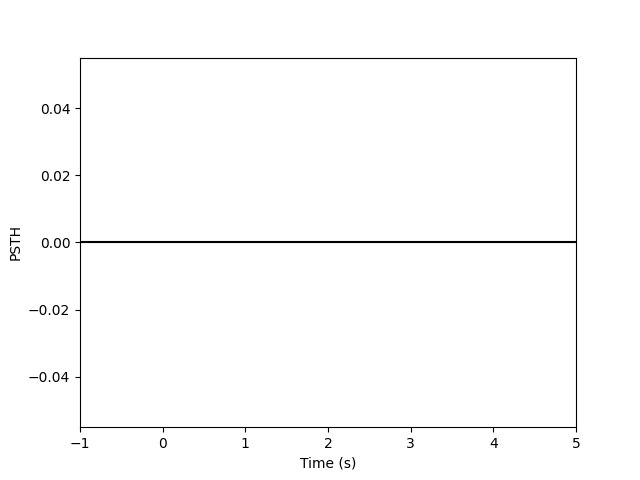

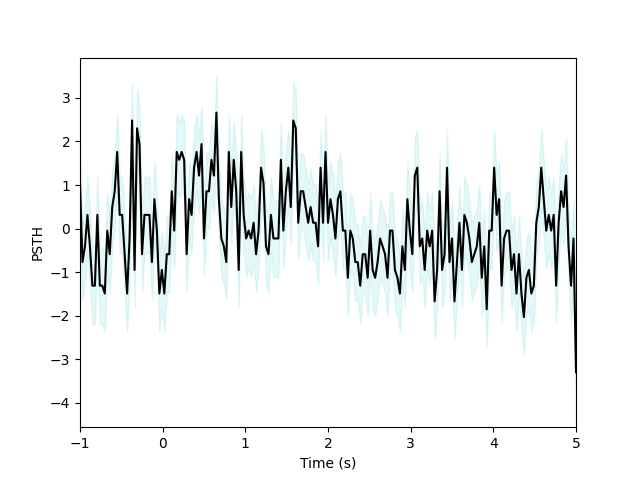

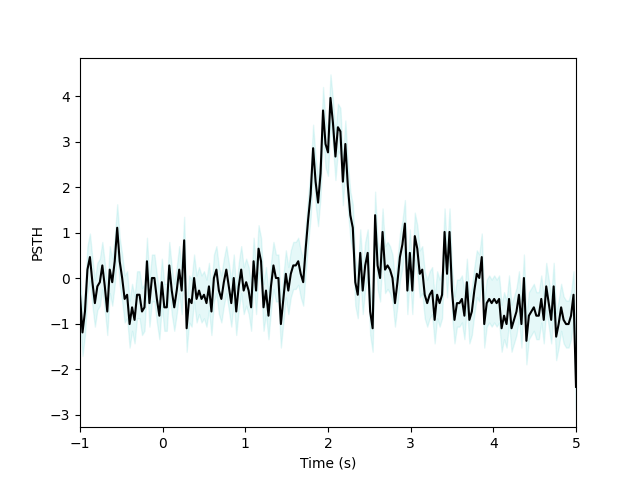

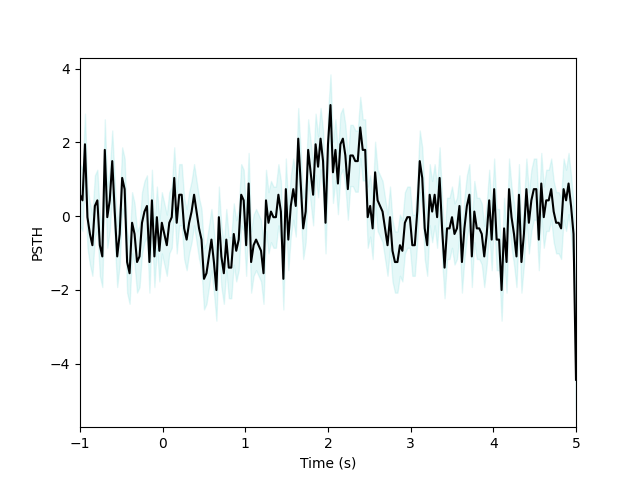

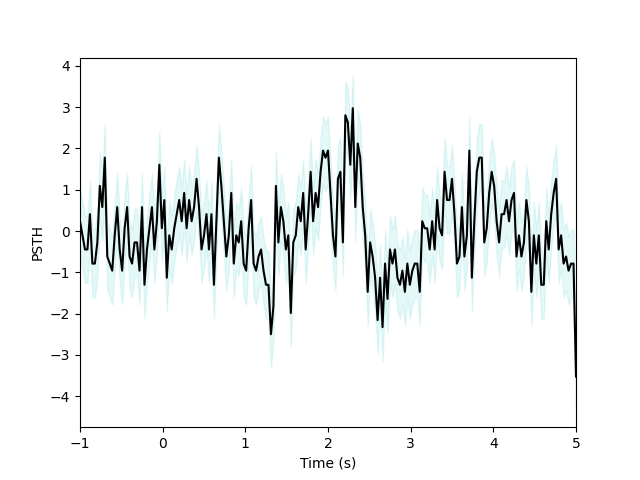

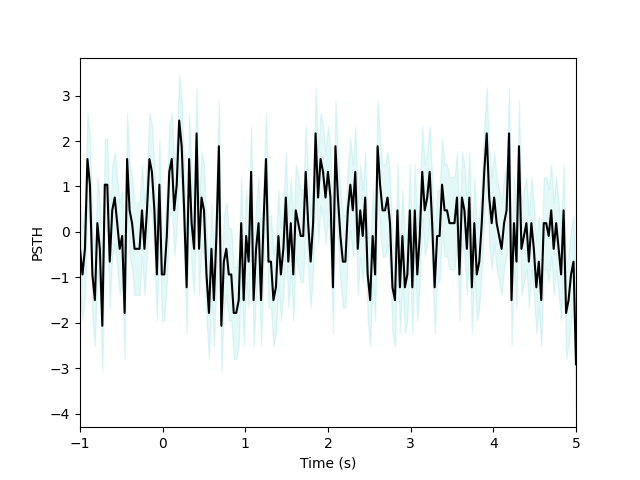

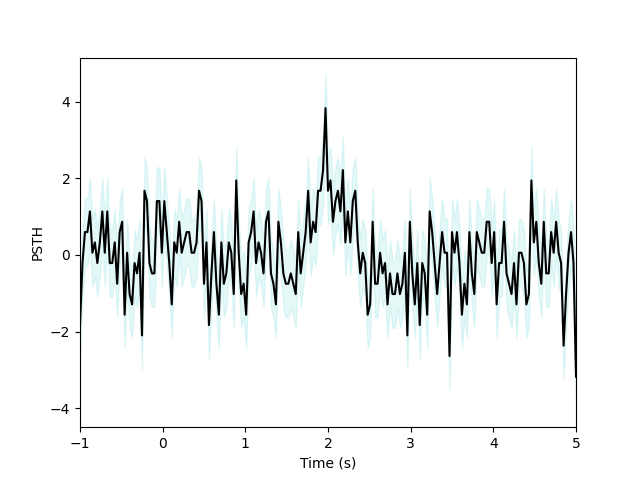

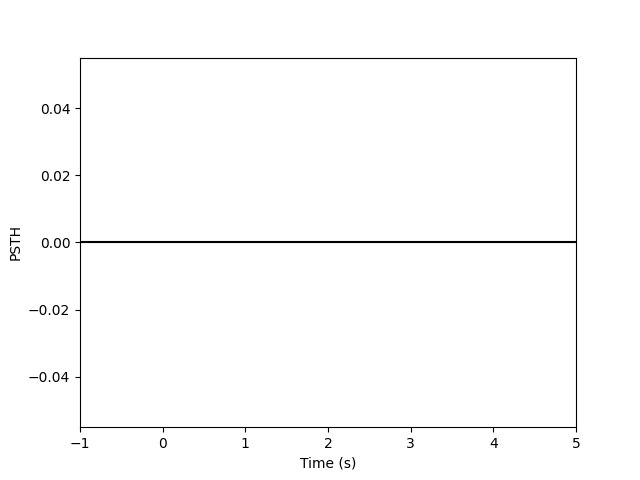

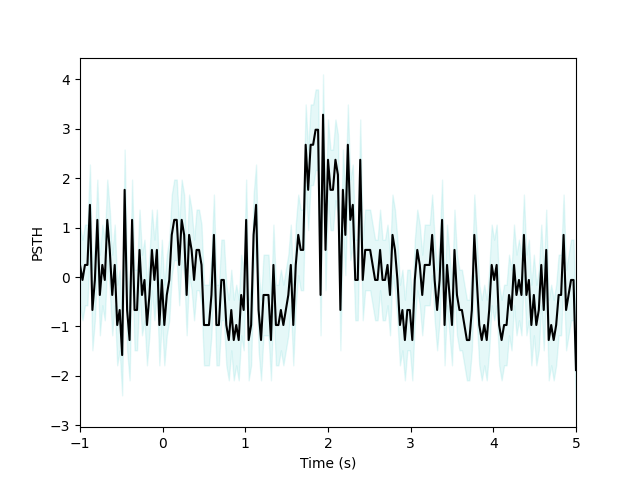

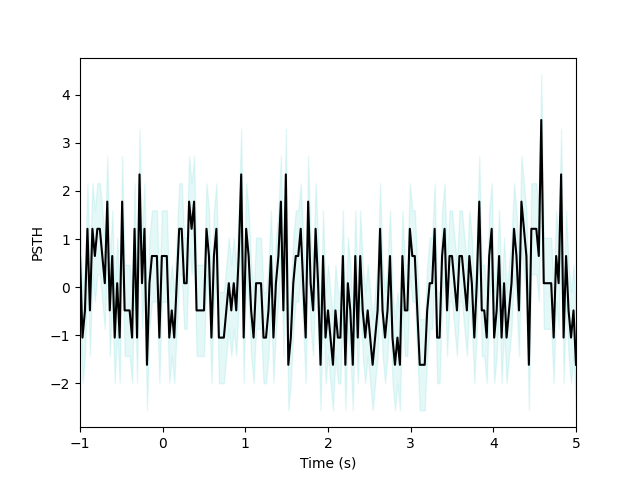

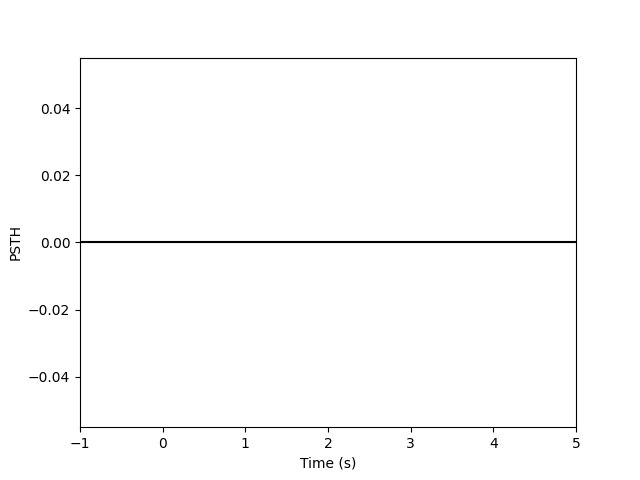

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [83]:
[plotPSTH(SpikeTimesMUA['second']['CW'][tet]) for tet in range(Ntet)]

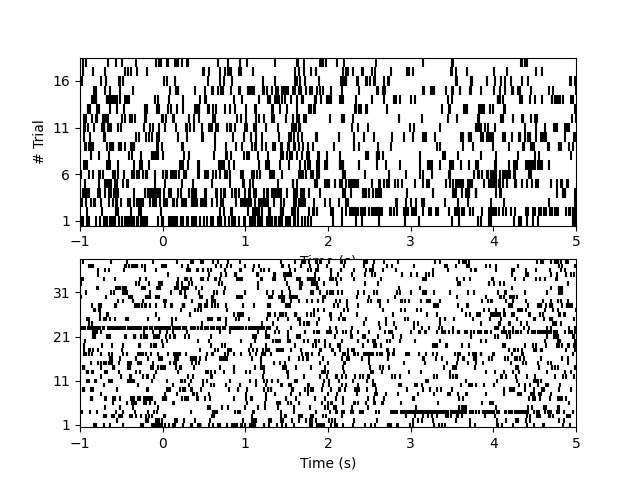

In [71]:
tet = 0

plots(2,1,
      lambda ax: plotRaster(SpikeTimesMUA['first']['CW'][tet], ax=ax),
      lambda ax: plotRaster(SpikeTimesMUA['second']['CW'][tet], ax=ax, ylabel=False)
)

END OF WORK

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>All spiking times</strong></span>

In [28]:
## Spike times organized by cluster

AllSpikeTimes = np.empty((Nclust, Ntrial), dtype=object)

for unit in range(Nclust):
    spikingTimeClus = temp_time_clust[unit]  # Accéder aux temps de spikes pour le cluster actuel
    # Itérer à travers chaque essai (trial)
    for trial in range(Ntrial):
        upperTime = pic_position[trial] / f + timeAft
        lowerTime = pic_position[trial] / f - timeBef
        # Obtenir les indices des temps de spikes qui vérifient la condition
        bornes = np.logical_and(lowerTime < spikingTimeClus, spikingTimeClus < upperTime)
        # Ajouter les temps de spikes vérifiant la condition à AllSpikeTimes
        AllSpikeTimes[unit][trial] = spikingTimeClus[bornes] - lowerTime - timeBef

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Spiking times depending on conditions</strong></span>

In [29]:
SpikeTimes = {
    'first': {
        'CW': [[] for _ in range(Nclust)],
        'CCW': [[] for _ in range(Nclust)],
        'NotResponding': [[] for _ in range(Nclust)]
    },
    'second': {
        'CW': [[] for _ in range(Nclust)],
        'CCW': [[] for _ in range(Nclust)],
        'NotResponding': [[] for _ in range(Nclust)]
    }
}


for neuron in range(len(AllSpikeTimes)):
    for trial in range(Ntrial):
        if trial < thresholdTrial:
            condition = 'first'
            trialIndex = trial
            if RotationWise[condition][trialIndex] == 'CW':
                direction = 'CW'
            elif RotationWise[condition][trialIndex] == 'CCW':
                direction = 'CCW'
            elif RotationWise[condition][trialIndex] == 'NotResponding':
                direction = 'NotResponding'
        else:
            condition = 'second'
            trialIndex = trial - thresholdTrial
            if RotationWise[condition][trialIndex] == 'CW':
                direction = 'CW'
            elif RotationWise[condition][trialIndex] == 'CCW':
                direction = 'CCW'
            elif RotationWise[condition][trialIndex] == 'NotResponding':
                direction = 'NotResponding'
        
        SpikeTimes[condition][direction][neuron].append([AllSpikeTimes[neuron][trial]])


for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            SpikeTimes[condition][direction][unit] = np.array([SpikeTimes[condition][direction][unit][trial][0] for trial in range(len(SpikeTimes[condition][direction][unit]))], dtype=object)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Velocity plot</strong></span>

In [30]:
MeanRotation = {
    'first': {
        'CW' : [],
        'CCW': [],
        'NotResponding': []
    },
    'second': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    },
}


for condition in ['first','second']:
    for direction in ['CW','CCW','NotResponding']:
        stock_velocities = []
        for trial in range(len(Rotation[condition][direction])):
            baseline = Rotation[condition][direction][trial][:1*f]
            unreduced = savgol_filter(Rotation[condition][direction][trial],50,3) - np.mean(baseline)
            operational_velocity = unreduced / max(abs(unreduced))*rotationSpeed
            stock_velocities.append(operational_velocity)

        MeanRotation[condition][direction] = np.mean(stock_velocities, axis=0)

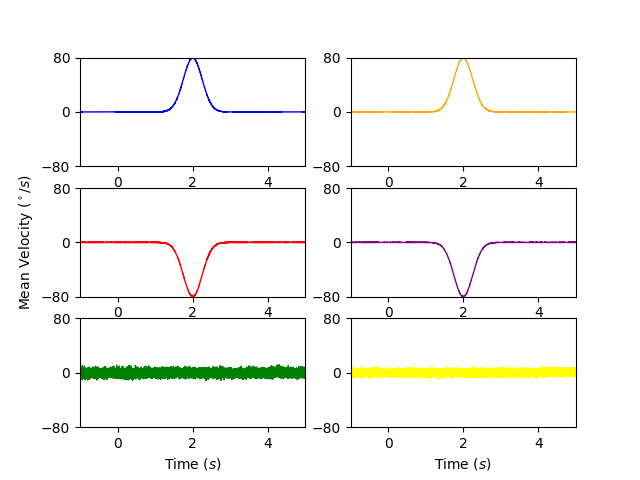

In [31]:
plots(3, 2,
      lambda ax: plotVelocity(MeanRotation['first']['CW'], 'blue', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['first']['CCW'], 'red', ax, xlabel=False, ylabel=True),
      lambda ax: plotVelocity(MeanRotation['first']['NotResponding'], 'green', ax, xlabel=True, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['CW'], 'orange', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['CCW'], 'purple', ax, xlabel=False, ylabel=False),
      lambda ax: plotVelocity(MeanRotation['second']['NotResponding'], 'yellow', ax, xlabel=True, ylabel=False)
     )

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>Raster plots</strong></span>

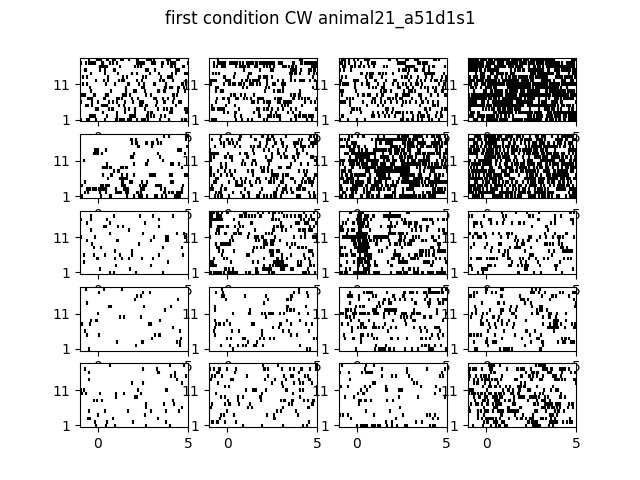

In [32]:
condition = 'first'
direction = 'CW'

plots(int(len(SpikeTimes[condition][direction])/4), 4,
      *[(lambda neuron: lambda ax: plotRaster(SpikeTimes[condition][direction][neuron], 'k', ax, xlabel=False, ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

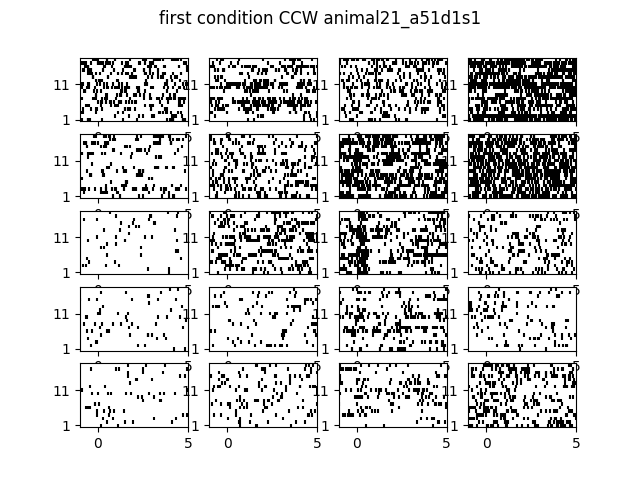

In [33]:
condition = 'first'
direction = 'CCW'

plots(int(len(SpikeTimes[condition][direction])/4), 4,
      *[(lambda neuron: lambda ax: plotRaster(SpikeTimes[condition][direction][neuron], 'k', ax, xlabel=False, ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

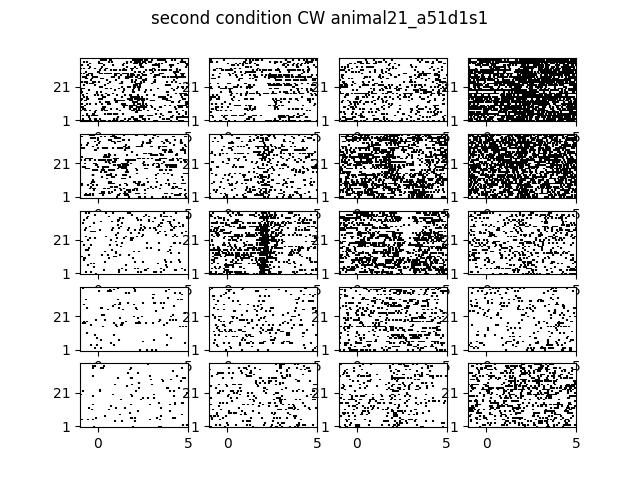

In [34]:
condition = 'second'
direction = 'CW'

plots(int(len(SpikeTimes[condition][direction])/4), 4,
      *[(lambda neuron: lambda ax: plotRaster(SpikeTimes[condition][direction][neuron], 'k', ax, xlabel=False, ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

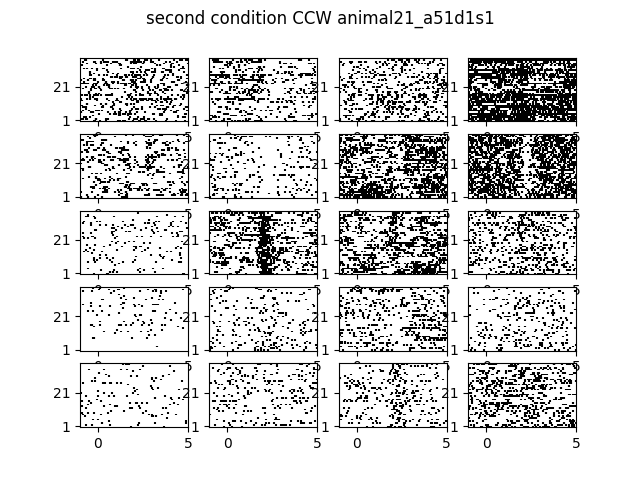

In [35]:
condition = 'second'
direction = 'CCW'

plots(int(len(SpikeTimes[condition][direction])/4), 4,
      *[(lambda neuron: lambda ax: plotRaster(SpikeTimes[condition][direction][neuron], 'k', ax, xlabel=False, ylabel=False))(neuron) for neuron in range(len(SpikeTimes[condition][direction]))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>PSTH</strong></span>

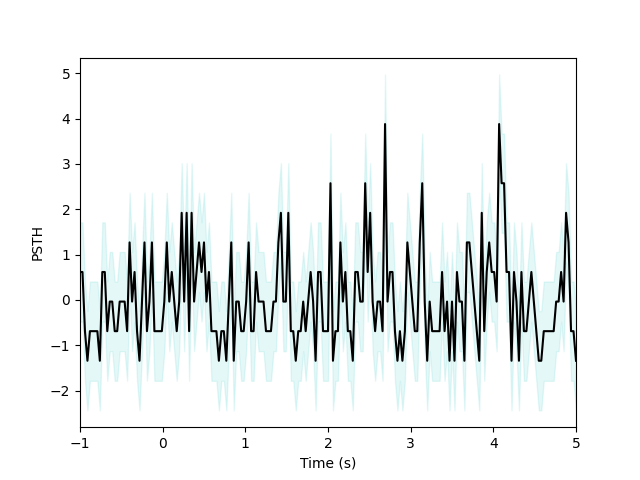

In [36]:
plotPSTH(SpikeTimes['first']['CW'][0],binResolution=0.03)

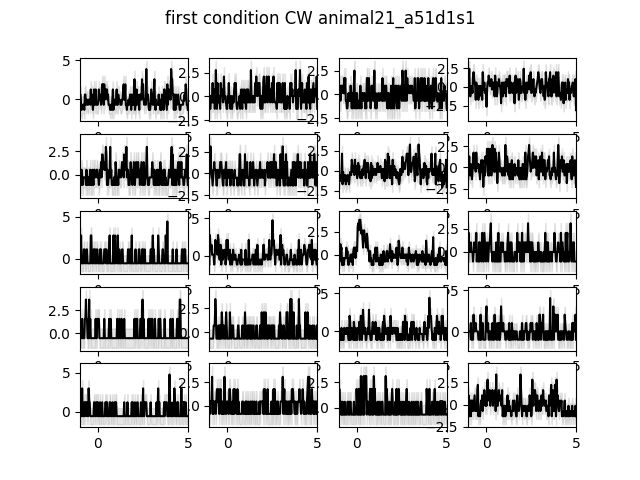

In [37]:
condition = 'first'
direction = 'CW'

StudiedSpikeTimes = SpikeTimes[condition][direction]

plots(int(len(StudiedSpikeTimes)/4), 4,
      *[(lambda neuron: lambda ax: plotPSTH(StudiedSpikeTimes[neuron],'k', 'k', ax=ax,xlabel=False,ylabel=False))(neuron) for neuron in range(len(StudiedSpikeTimes))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

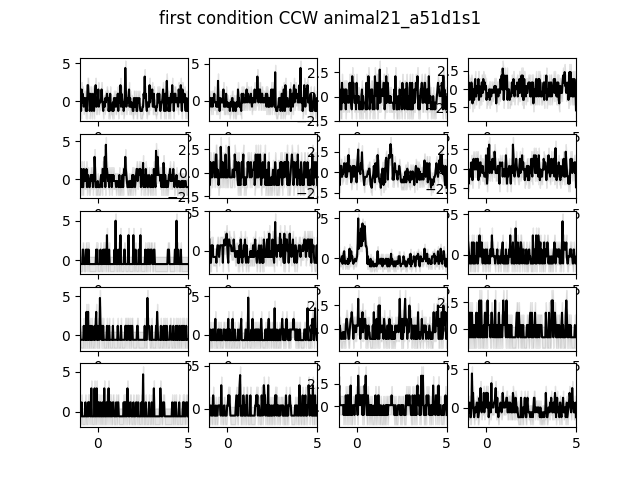

In [38]:
condition = 'first'
direction = 'CCW'

StudiedSpikeTimes = SpikeTimes[condition][direction]

plots(int(len(StudiedSpikeTimes)/4), 4,
      *[(lambda neuron: lambda ax: plotPSTH(StudiedSpikeTimes[neuron],'k', 'k', ax=ax,xlabel=False,ylabel=False))(neuron) for neuron in range(len(StudiedSpikeTimes))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

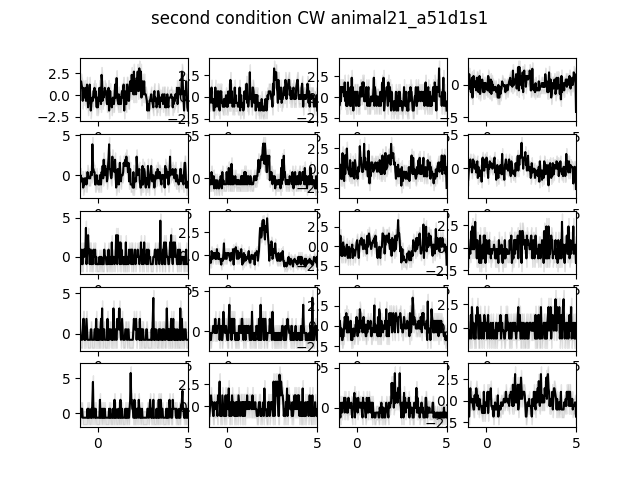

In [39]:
condition = 'second'
direction = 'CW'

StudiedSpikeTimes = SpikeTimes[condition][direction]

plots(int(len(StudiedSpikeTimes)/4), 4,
      *[(lambda neuron: lambda ax: plotPSTH(StudiedSpikeTimes[neuron],'k', 'k', ax=ax,xlabel=False,ylabel=False))(neuron) for neuron in range(len(StudiedSpikeTimes))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

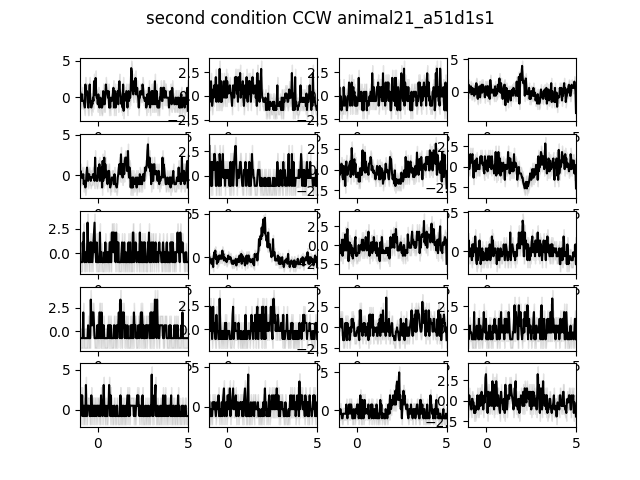

In [40]:
condition = 'second'
direction = 'CCW'

StudiedSpikeTimes = SpikeTimes[condition][direction]

plots(int(len(StudiedSpikeTimes)/4), 4,
      *[(lambda neuron: lambda ax: plotPSTH(StudiedSpikeTimes[neuron],'k', 'k', ax=ax,xlabel=False,ylabel=False))(neuron) for neuron in range(len(StudiedSpikeTimes))],
      suptitle=condition+' condition '+direction+' '+exp_id
)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>FIGURE 1</strong></span>

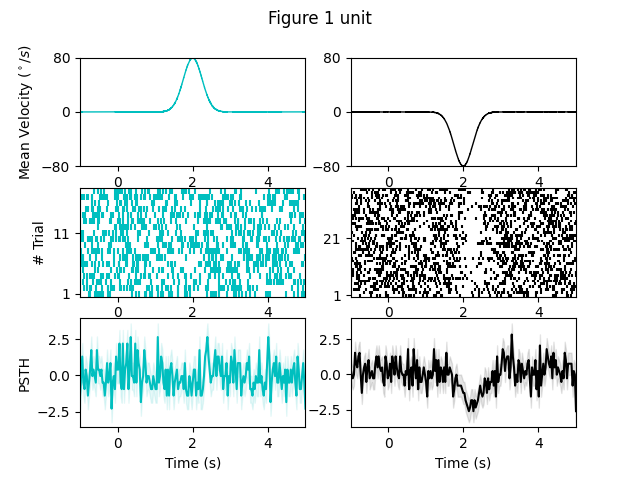

In [41]:
unit = 16

figure1(unit)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6"><strong>PSTH Heatmap</strong></span>

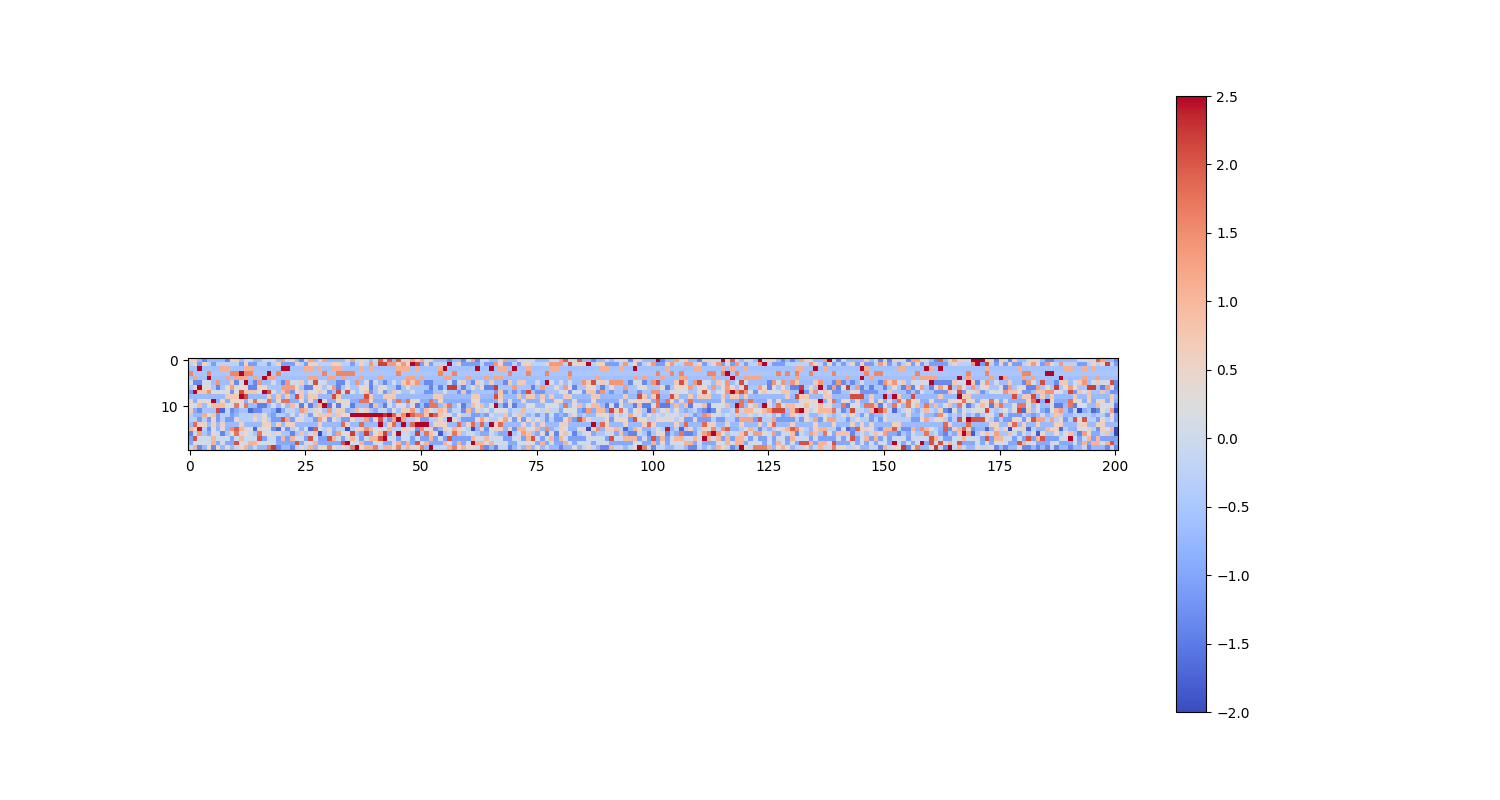

In [42]:
Zmaxiscore = [[] for _ in range(len(SpikeTimes['first']['CW']))]

for unit in range(len(SpikeTimes['first']['CW'])):
    StudiedSpikeTimes = SpikeTimes['first']['CW'][unit]

    color='k'
    shadedcolor='k'
    ylabel=True
    xlabel=True

    local_trial_number = len(StudiedSpikeTimes)

    binResolution=0.03

    spike_number_per_trial = [[] for _ in range(local_trial_number)]
    edges = []
    unitary_firing_rate = [[] for _ in range(local_trial_number)]

    for trial in range(local_trial_number):
        spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

    frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
    mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

    Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency)
    Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency)
    SEM = np.std(Zunitary)/np.sqrt(len(Zunitary))

    # # plt.figure(figsize=(15,6))
    # plt.plot(edges[:-1], Zscore, color=color)
    # plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
    # plt.xlim(-timeBef,timeAft)
    # if ylabel:
    #     plt.ylabel('PSTH')
    # if xlabel:
    #     plt.xlabel('Time (s)')
    # plt.show()

    Zmaxiscore[unit] = Zscore



# del Zmaxiscore[22]


# # Créer des données aléatoires pour le heatmap (une matrice 10x10)
# data = np.random.rand(10, 100)

# Afficher le heatmap
plt.figure(figsize=(15,8))
plt.imshow(Zmaxiscore, cmap='coolwarm', interpolation='nearest', vmin=-2,vmax=2.5)
plt.colorbar()  # Ajouter une barre de couleur pour référence
# plt.xticks(duration)
plt.show()

# Statistics

## Spike Counting

In [43]:
windowDurArray = np.where(abs(MeanRotation['first']['CW'])>40)
windowDur = [windowDurArray[0][0],windowDurArray[0][-1]]
windowLen = len(windowDurArray[0])
windowBef = [1*f, 1*f+windowLen]

numberBef = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
numberDur = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}
diffBefDur = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}

for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            for trial in range(len(SpikeTimes[condition][direction][unit])):

                lowerBef = SpikeTimes[condition][direction][unit][trial] > duration[windowBef[0]]
                upperBef = SpikeTimes[condition][direction][unit][trial] < duration[windowBef[1]]
                lowerDur = SpikeTimes[condition][direction][unit][trial] > duration[windowDur[0]]
                upperDur = SpikeTimes[condition][direction][unit][trial] < duration[windowDur[1]]

                numberBef[condition][direction][unit].append(np.count_nonzero(lowerBef & upperBef))
                numberDur[condition][direction][unit].append(np.count_nonzero(lowerDur & upperDur))

            diffBefDur[condition][direction][unit] = np.mean(numberDur[condition][direction][unit]) - np.mean(numberBef[condition][direction][unit])

## Paired Wilcoxon Test

In [44]:
statistics = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}

p_values = {
    'first': {
        'CW': [[] for _ in range(len(SpikeTimes['first']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['first']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['first']['NotResponding']))]
    },
    'second': {
        'CW': [[] for _ in range(len(SpikeTimes['second']['CW']))],
        'CCW': [[] for _ in range(len(SpikeTimes['second']['CCW']))],
        'NotResponding': [[] for _ in range(len(SpikeTimes['second']['NotResponding']))]
    }
}



for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        for unit in range(len(SpikeTimes[condition][direction])):
            results = wilcoxon(numberBef[condition][direction][unit], numberDur[condition][direction][unit])
            statistics[condition][direction][unit].append(results[0])
            p_values[condition][direction][unit].append(results[1])


C:\Users\gbouvier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\gbouvier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
print(numberBef['first']['CW'][0])

print(numberDur['first']['CW'][0])

print(statistics['first']['CW'][0])

print(p_values['first']['CW'][0])

[1, 1, 2, 1, 7, 1, 2, 6, 0, 0, 1, 3, 1, 1, 2, 12, 5, 10]
[4, 6, 1, 3, 0, 1, 2, 1, 2, 0, 1, 1, 0, 6, 0, 3, 2, 4]
[36.5]
[0.31325979204535026]


## Determination of significant units by condition & rotation

In [46]:
p_value_threshold = 0.05

significance = {
    'first': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    },
    'second': {
        'CW': [],
        'CCW': [],
        'NotResponding': []
    }
}

for condition in SpikeTimes:
    for direction in SpikeTimes[condition]:
        significance[condition][direction] = np.where([p_values[condition][direction][neuron][0]<p_value_threshold for neuron in range(Nclust)])

## Visual Overview Of Spike Numbers Before & During

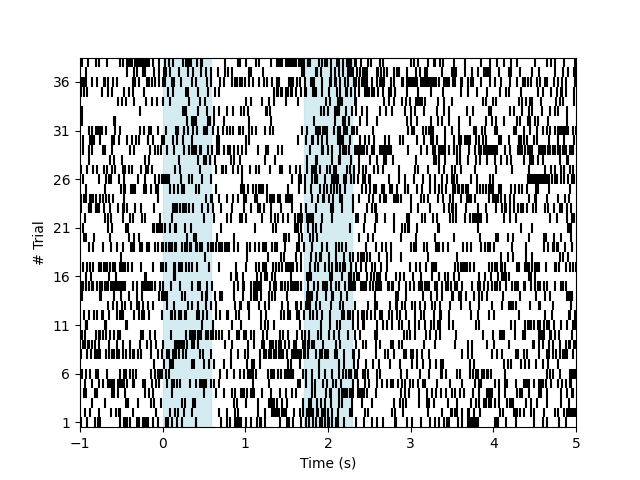

Number of spikes before rotation : [8, 5, 4, 2, 13, 2, 8, 11, 14, 12, 1, 11, 7, 8, 6, 3, 12, 1, 18, 3, 6, 2, 13, 2, 7, 8, 3, 5, 10, 5, 11, 6, 5, 4, 6, 9, 10, 14]
Number of spikes during rotation : [13, 14, 9, 13, 8, 10, 3, 11, 8, 8, 4, 10, 8, 10, 12, 8, 12, 8, 9, 3, 5, 6, 5, 9, 10, 13, 11, 7, 10, 11, 15, 5, 8, 5, 12, 12, 11, 15]
True


In [49]:
condition = 'second'
direction = 'CW'
unit = 15

plotRaster(SpikeTimes[condition][direction][unit],
            extra=lambda: (
                plt.axvspan(duration[windowBef[0]], duration[windowBef[1]], color='lightblue', alpha=0.5),
                plt.axvspan(duration[windowDur[0]], duration[windowDur[1]], color='lightblue', alpha=0.5)
            )
            )

print(f'Number of spikes before rotation : {numberBef[condition][direction][unit]}')
print(f'Number of spikes during rotation : {numberDur[condition][direction][unit]}')
print(len(numberBef[condition][direction][unit])==len(numberDur[condition][direction][unit]))

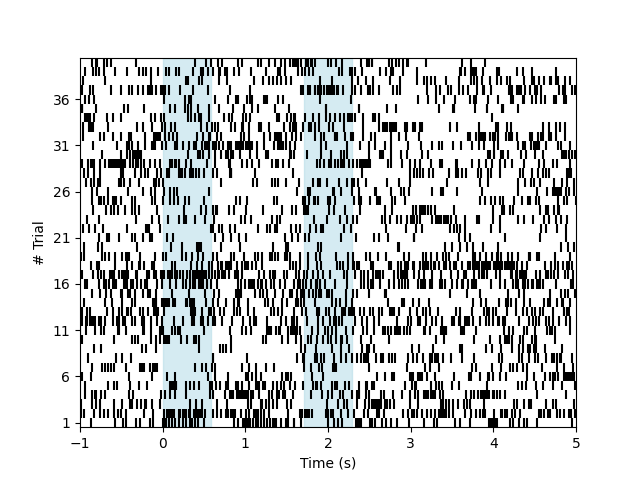

(array([0], dtype=int64),)
[15, 24, 3, 5, 11, 3, 3, 0, 1, 10, 6, 7, 7, 15, 3, 12, 20, 6, 6, 5, 2, 1, 6, 3, 7, 5, 1, 13, 8, 5, 12, 8, 5, 7, 7, 4, 6, 4, 8, 3]
[4, 12, 4, 7, 9, 2, 8, 9, 5, 10, 7, 8, 14, 5, 10, 11, 8, 7, 5, 2, 3, 6, 4, 6, 8, 6, 6, 0, 11, 6, 3, 8, 7, 10, 2, 2, 18, 3, 7, 10]


In [60]:
condition = 'second'
direction = 'NotResponding'
unit = 15

plotRaster(SpikeTimes[condition][direction][unit],
            extra=lambda: (
                plt.axvspan(duration[windowBef[0]], duration[windowBef[1]], color='lightblue', alpha=0.5),
                plt.axvspan(duration[windowDur[0]], duration[windowDur[1]], color='lightblue', alpha=0.5)
            )
            )

print(significance['second']['NotResponding'])

print(numberBef['second']['NotResponding'][unit])
print(numberDur['second']['NotResponding'][unit])

## Resuming modulation

In [61]:
modulation = {
    'first': [{
        'selectivity': [],
        'type': []
    } for _ in range(Nclust)],
    'second': [{
        'selectivity': [],
        'type': []
    } for _ in range(Nclust)]
}



for unit in range(Nclust):
    for condition in significance:

        both = (unit in significance[condition]['CW'][0]) and (unit in significance[condition]['CCW'][0])
        CW = unit in significance[condition]['CW'][0]
        CCW = unit in significance[condition]['CCW'][0]



        if not (both or CW or CCW):
            modulation[condition][unit]['selectivity'] = 'unmodulated'
            modulation[condition][unit]['type'] = '0'
        else:
            if both:
                modulation[condition][unit]['selectivity'] = 'both'
                if (diffBefDur[condition]['CW'][unit] >= 0) and (diffBefDur[condition]['CCW'][unit] >= 0):
                    modulation[condition][unit]['type'] = '+/+'
                elif (diffBefDur[condition]['CW'][unit] < 0) and (diffBefDur[condition]['CCW'][unit] < 0):
                    modulation[condition][unit]['type'] = '-/-'
                elif (diffBefDur[condition]['CW'][unit] < 0) and (diffBefDur[condition]['CCW'][unit] >= 0):
                    modulation[condition][unit]['type'] = '-/+'
                elif (diffBefDur[condition]['CW'][unit] >= 0) and (diffBefDur[condition]['CCW'][unit] < 0):
                    modulation[condition][unit]['type'] = '+/-'
            elif CW:
                modulation[condition][unit]['selectivity'] = 'CW'
                modulation[condition][unit]['type'] = '+' if diffBefDur[condition]['CW'][unit] >= 0 else '-'
            elif CCW:
                modulation[condition][unit]['selectivity'] = 'CCW'
                modulation[condition][unit]['type'] = '+' if diffBefDur[condition]['CCW'][unit] >= 0 else '-'




# Convertir les listes en tableaux NumPy
for condition in modulation:
    modulation[condition] = np.array(modulation[condition])

The both +/+ modulated neurons are [ 7 14 15 17]


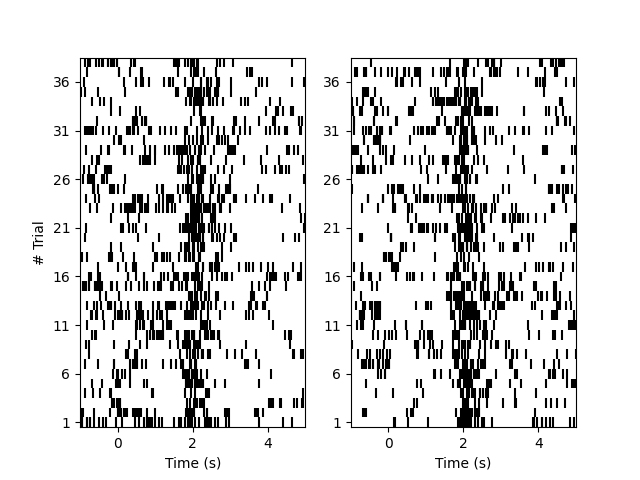

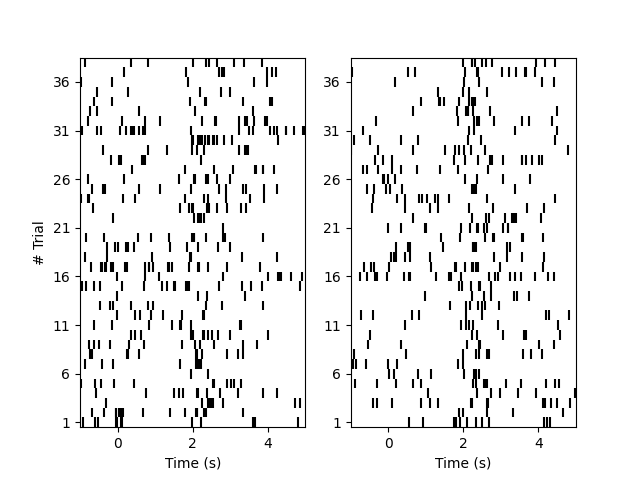

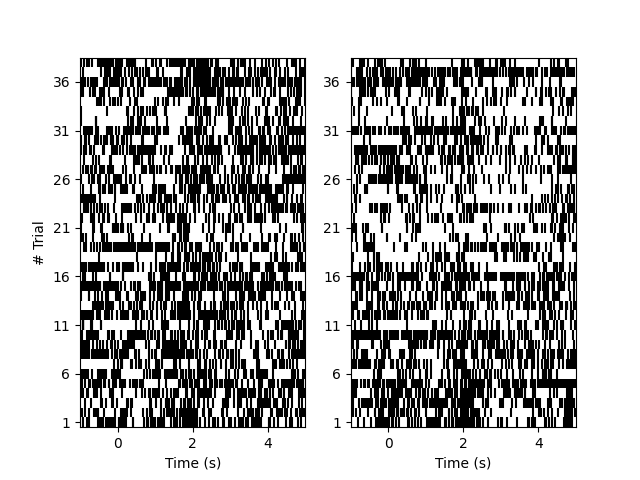

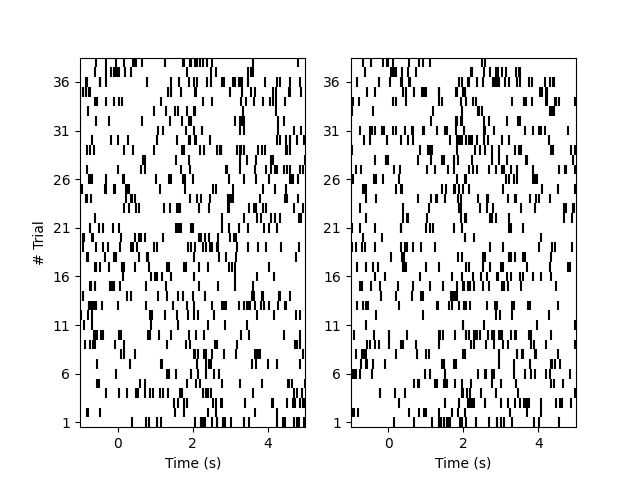

In [62]:
seeModulation('second', 'both +/+')

## Showing Numerical Results

In [63]:
condition = 'first'

print(f"Number of neurons responding to rotation : {sum([np.count_nonzero([modulation[condition][neuron]['selectivity']==value for value in ['CW','CCW','both']]) for neuron in range(Nclust)])}/{Nclust}\n")
print(f"CW modulation : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust)])}")
print(f"CCW modulation : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust)])}")
print(f"Selective to both : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust)])}")
print(f"Unmodulated : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'unmodulated' for neuron in range(Nclust)])}")

Number of neurons responding to rotation : 4/20

CW modulation : 1
CCW modulation : 2
Selective to both : 1
Unmodulated : 16


In [64]:
condition = 'second'

print(f"Number of neurons responding to rotation : {sum([np.count_nonzero([modulation[condition][neuron]['selectivity']==value for value in ['CW','CCW','both']]) for neuron in range(Nclust)])}/{Nclust}\n")
print(f"CW modulation : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust)])}")
print(f"CCW modulation : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust)])}")
print(f"Selective to both : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust)])}")
print(f"Unmodulated : {np.count_nonzero([modulation[condition][neuron]['selectivity'] == 'unmodulated' for neuron in range(Nclust)])}")

Number of neurons responding to rotation : 13/20

CW modulation : 2
CCW modulation : 4
Selective to both : 7
Unmodulated : 7


In [65]:
print(f"Unit CW of first condition, significant modulation : {significance['first']['CW'][0]}\n")

print(f"Unit CCW of first condition, significant modulation : {significance['first']['CCW'][0]}\n")

print(f"Unit CW of second condition, significant modulation : {significance['second']['CW'][0]}\n")

print(f"Unit CCW of second condition, significant modulation : {significance['second']['CCW'][0]}")


Unit CW of first condition, significant modulation : [12 16]

Unit CCW of first condition, significant modulation : [ 5 12 19]

Unit CW of second condition, significant modulation : [ 2  4  5  6  7 14 15 16 17]

Unit CCW of second condition, significant modulation : [ 0  1  5  6  7  8  9 14 15 16 17]
